<a href="https://colab.research.google.com/github/verneh/transformers/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Ian Goodfellow version of GAN.

Loss function from the paper: 

$[log D(x)] + [log(1 − D(G(z)))]$

In [1]:
# import libraries
import torch
from torch import nn
from torch import optim
from torchvision.transforms import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

# Tensor Transform

torch.Size([3, 32, 32])


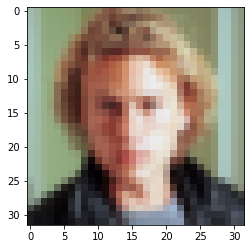

In [3]:
# transform image
transform = transforms.Compose([
                                transforms.Resize((32, 32)),
                                transforms.ToTensor()
])

flat_img = 3072  # 32×32×3 -- size of flattened image in order to train through colab.

img = Image.open('/content/heath.jpg')
real_img = transform(img)

torch.manual_seed(2)
fake_img = torch.rand(1, 100)

plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
print(real_img.size())

# Modules

Create a discriminator model which is nothing but a fully connected neural network which takes in a real image or fake image and outputs 0 or 1.

In [4]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(flat_img, 10000),
        nn.ReLU(),
        nn.Linear(10000, 1),
        nn.Sigmoid()
    )

  def forward(self, img):
    img = img.view(1, -1)
    out = self.linear(img)

    return out

Create a generator model which is also a fully connected network which takes in a random noise and outputs an image tensor which is of the same size as the real image.

In [5]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
        nn.Linear(100, 10000),
        nn.LeakyReLU(), # allow a small, positive gradient when the unit is not active.
        nn.Linear(10000, 4000),
        nn.LeakyReLU(),
        nn.Linear(4000, flat_img)
    )

  def forward(self, latent_space):
    latent_space = latent_space.view(1, -1)
    out = self.linear(latent_space)

    return out

# Initialization

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

discr = Discriminator().to(device)
gen = Generator().to(device)

opt_d = optim.SGD(discr.parameters(), lr=0.001, momentum=0.9)
opt_g = optim.SGD(gen.parameters(), lr=0.001, momentum=0.9)

criterion = nn.BCELoss()

# Training

In [7]:
epochs = 500
discr_e = 4 
gen_e = 3

#whole model training starts here
for epoch in tqdm(range(epochs), total=epochs):

  #discriminator training
  for k in range(discr_e):
    opt_d.zero_grad()

    out_d1 = discr(real_img.to(device))
    #loss for real image
    loss_d1 = criterion(out_d1, torch.ones((1, 1)).to(device))
    loss_d1.backward()

    out_d2 = gen(fake_img.to(device)).detach()
    #loss for fake image
    loss_d2 = criterion(discr(out_d2.to(device)), torch.zeros((1, 1)).to(device))
    loss_d2.backward()

    opt_d.step()

  #generator training
  for i in range(gen_e):
    opt_g.zero_grad()
    
    out_g = gen(fake_img.to(device))
    
    #Binary cross entropy loss
    #loss_g =  criterion(discr(out_g.to(device)), torch.ones(1, 1).to(device))

    #----Loss function in the GAN paper
    #[log(1 - D(G(z)))]
    loss_g = torch.log(1.0 - (discr(out_g.to(device)))) 
    loss_g.backward()

    opt_g.step()

  0%|          | 0/500 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


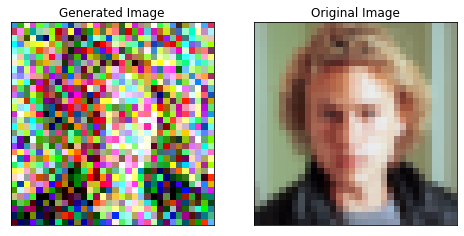

In [8]:
# Original and generated image.
plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.title("Generated Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(out_g.resize(3, 32, 32).cpu().detach().numpy(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.title("Original Image")
plt.xticks([])
plt.yticks([])
plt.imshow(np.transpose(real_img.numpy(), (1, 2, 0)))
plt.show()